## Load data (colab environment)

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
PRODUCTS_PATH = 'drive/MyDrive/data - MoMD'

In [46]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import get_json_object, from_json, regexp_replace, col
from pyspark.sql.types import *

spark = SparkSession.builder.appName('Office').getOrCreate()

review_df = spark.read.json(PRODUCTS_PATH + '/Office_Products.jsonl')

In [47]:
meta_schema = StructType([
    StructField("main_category", StringType(), True),
    StructField("title", StringType(), True),
    StructField("average_rating", DoubleType(), True),
    StructField("rating_number", LongType(), True),
    StructField("features", ArrayType(StringType()), True),
    StructField("description", ArrayType(StringType()), True),
    StructField("price", DoubleType(), True),
    StructField("images", ArrayType(MapType(StringType(), StringType())), True),
    StructField("videos", ArrayType(MapType(StringType(), StringType())), True),
    StructField("store", StringType(), True),
    StructField("categories", ArrayType(StringType()), True),

    StructField("details", StringType(), True),

    StructField("parent_asin", StringType(), True),
    StructField("bought_together", DoubleType(), True),
    StructField("subtitle", StringType(), True),
    StructField("author", StringType(), True),
])

raw_meta_df = spark.read.text(PRODUCTS_PATH + "/meta_Office_Products.jsonl")

meta_df = (
    raw_meta_df
    .select(from_json(col("value"), meta_schema).alias("data"))
    .select("data.*")
)

## Item

In [48]:
joined_df = review_df.join(
    meta_df.select("parent_asin"),
    on="parent_asin",
    how="left"
)

### Reviews / item

In [6]:
from pyspark.sql.functions import count, avg

review_stat = joined_df.groupBy("parent_asin").agg(
    count("*").alias("review_count"),
    avg("rating").alias("avg_rating")
)

In [ ]:
review_stat.describe().show()

+-------+--------------------+------------------+-----------------+
|summary|         parent_asin|      review_count|       avg_rating|
+-------+--------------------+------------------+-----------------+
|  count|              710403|            710403|           710403|
|   mean|1.9191196864709792E9|18.082288503849224|4.139702315329243|
| stddev| 1.780190154219129E9|124.04239374339363|1.100193988228129|
|    min|          0000306002|                 1|              1.0|
|    max|          BT008UKTMW|             32645|              5.0|
+-------+--------------------+------------------+-----------------+



### Visualization

In [6]:
import matplotlib.pyplot as plt

In [19]:
rating_rdd = review_stat.rdd.map(lambda row: row.avg_rating)

In [20]:
bins, avg_ratings = rating_rdd.histogram(26)

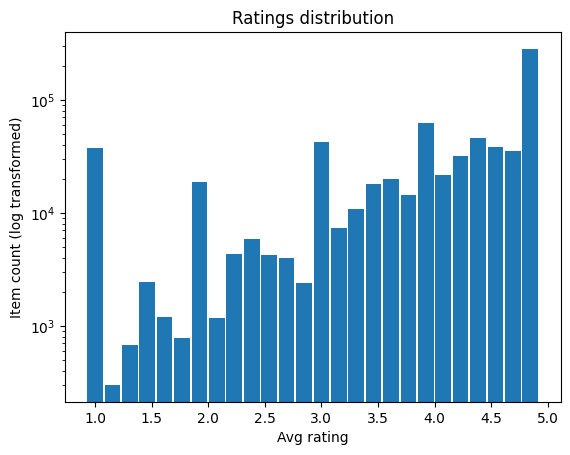

In [26]:
plt.bar(bins[:-1], avg_ratings, width=0.9*(bins[1] - bins[0]))
plt.yscale("log")
plt.xlabel("Avg rating")
plt.ylabel("Item count (log transformed)")
plt.title("Ratings distribution")
plt.show()

### Only 1 review rate

In [22]:
review_stat.filter(col("review_count") == 1).count()

260634

### Top 5 most rated items

In [14]:
top_asins = (
    review_stat
    .select("parent_asin", "review_count", "avg_rating")
    .rdd
    .takeOrdered(5, key=lambda x: -x.review_count)
)

top_asins = spark.createDataFrame(top_asins)

In [15]:
from pyspark.sql.functions import broadcast

top_items = top_asins.join(meta_df, on="parent_asin", how="left")

In [16]:
top_items.show(truncate=False)

+-----------+------------+------------------+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
top_items.select("parent_asin", "review_count", "avg_rating", col("average_rating").alias("avg_rating_meta"), col("rating_number").alias("rating_number_meta")).show(truncate=False)

+-----------+------------+------------------+---------------+------------------+
|parent_asin|review_count|avg_rating        |avg_rating_meta|rating_number_meta|
+-----------+------------+------------------+---------------+------------------+
|B0BZ67T58M |12135       |4.852575195714874 |4.8            |44539             |
|B00AVWKUJS |11768       |3.5427430319510536|3.9            |15290             |
|B087S2JRXY |32645       |4.139378158982999 |4.6            |201726            |
|B0BM61RCJQ |22215       |4.3279765923925275|4.4            |96511             |
|B0BSYNLRBY |11221       |4.195882719900188 |4.5            |66103             |
+-----------+------------+------------------+---------------+------------------+



### 5 stars items

In [11]:
max_rating_asins = review_stat.filter(col("avg_rating") == 5)

In [12]:
max_rating_items = max_rating_asins.join(meta_df, on="parent_asin", how="left")

In [13]:
max_rating_items.count()

266262

In [20]:
max_rating_items \
  .select("review_count", "avg_rating", col("average_rating").alias("avg_rating_meta"), col("rating_number").alias("rating_number_meta")) \
  .describe().show()

+-------+------------------+----------+------------------+------------------+
|summary|      review_count|avg_rating|   avg_rating_meta|rating_number_meta|
+-------+------------------+----------+------------------+------------------+
|  count|            266262|    266262|            266262|            266262|
|   mean|1.9671451427541293|       5.0| 4.666156642705357| 39.28364918764225|
| stddev|2.2119748910160064|       0.0|0.4680049011592168| 538.6512404951242|
|    min|                 1|       5.0|               1.0|                 1|
|    max|               105|       5.0|               5.0|            179082|
+-------+------------------+----------+------------------+------------------+



In [21]:
max_rating_items.filter(col("review_count") == 1).count()

167593

In [22]:
167593 / 266262

0.6294289083684491

## Time

### Parse

In [7]:
from pyspark.sql.functions import to_date, year, month, dayofmonth, from_unixtime

time_parsed_df = (
    joined_df
    .withColumn(
        "ts",
        from_unixtime(col("timestamp") / 1000)
    )
    .withColumn("date", to_date("ts"))
    .withColumn("year", year("ts"))
    .withColumn("month", month("ts"))
    .withColumn("day", dayofmonth("ts"))
)

In [32]:
time_parsed_df.describe().show()

+-------+--------------------+--------------------+------------------+------------------+--------+--------------------+--------+--------------------+-------------------+------------------+-----------------+------------------+
|summary|         parent_asin|                asin|      helpful_vote|            rating|    text|           timestamp|   title|             user_id|                 ts|              year|            month|               day|
+-------+--------------------+--------------------+------------------+------------------+--------+--------------------+--------+--------------------+-------------------+------------------+-----------------+------------------+
|  count|            12845712|            12845712|          12845712|          12845712|12845712|            12845712|12845712|            12845712|           12845712|          12845712|         12845712|          12845712|
|   mean|1.8232148177332816E9|2.2490396487819705E9|0.8696842962071701| 4.207478417700786|Infinit

### Review count by date

In [29]:
count_by_date = time_parsed_df.groupBy("date").count().orderBy("date")

In [30]:
count_by_date.show()

+----------+-----+
|      date|count|
+----------+-----+
|1998-10-12|    1|
|1998-11-04|    1|
|1998-12-27|    1|
|1999-06-08|    1|
|1999-06-22|    1|
|1999-06-30|    1|
|1999-07-05|    1|
|1999-07-07|    1|
|1999-07-09|    1|
|1999-07-14|    1|
|1999-07-18|    1|
|1999-08-02|    1|
|1999-08-03|    1|
|1999-08-09|    1|
|1999-08-16|    1|
|1999-08-22|    1|
|1999-08-23|    1|
|1999-08-26|    1|
|1999-09-26|    1|
|1999-09-28|    1|
+----------+-----+
only showing top 20 rows


In [ ]:
count_by_date_pd = count_by_date.toPandas()

In [50]:
import pandas as pd

count_by_date_pd['date'] = pd.to_datetime(count_by_date_pd["date"])

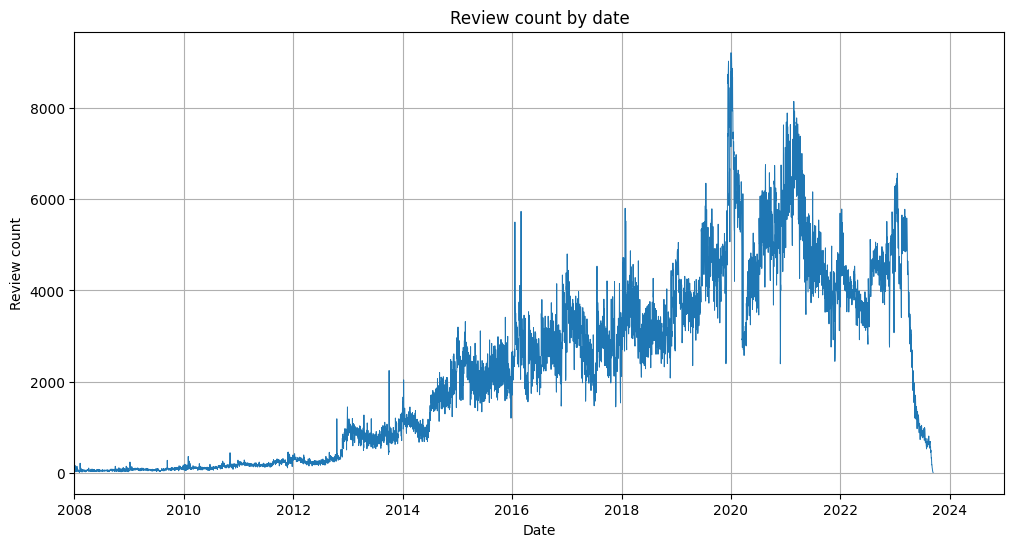

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(count_by_date_pd['date'], count_by_date_pd['count'], linestyle='-', linewidth=0.7)
plt.xlim(pd.Timestamp("2008-01-01"), pd.Timestamp("2024-12-31"))
plt.xlabel("Date")
plt.ylabel("Review count")
plt.title("Review count by date")
plt.grid(True)
plt.show()

### Review count by year

In [71]:
count_by_year = time_parsed_df.groupBy("year").count().orderBy("year")

In [76]:
count_by_year_pd = count_by_year.toPandas()

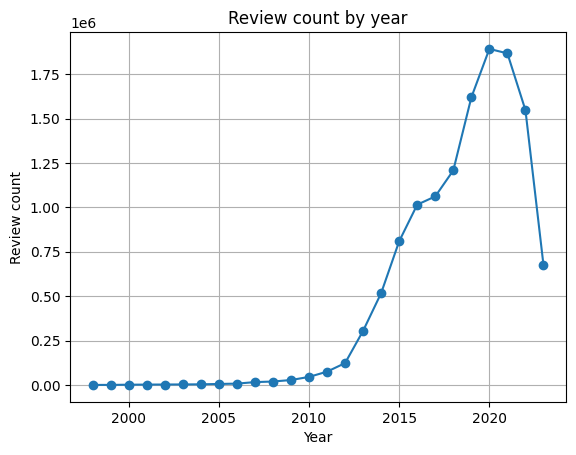

In [81]:
# plt.figure(figsize=(12, 6))
plt.plot(count_by_year_pd['year'], count_by_year_pd['count'], marker='o')
# plt.xlim(pd.Timestamp("2008-01-01"), pd.Timestamp("2024-12-31"))
plt.xlabel("Year")
plt.ylabel("Review count")
plt.title("Review count by year")
plt.grid(True)
plt.show()

### Review count by month

In [82]:
count_by_month = time_parsed_df.groupBy("month").count().orderBy("month")

In [83]:
count_by_month_pd = count_by_month.toPandas()

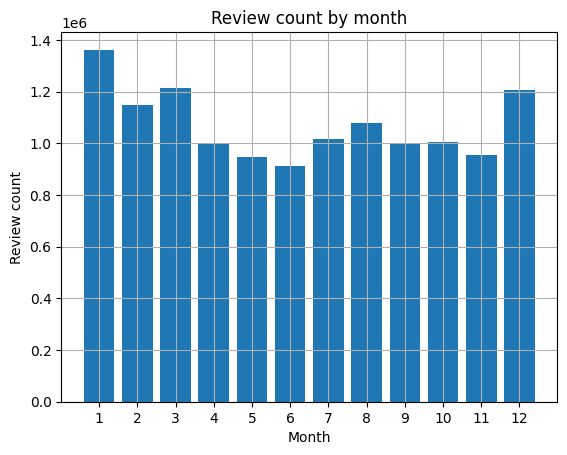

In [87]:
plt.bar(range(1, 13), count_by_month_pd['count'])
plt.xlabel("Month")
plt.ylabel("Review count")
plt.title("Review count by month")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

### Review trending

In [9]:
from pyspark.sql.functions import count, avg

trend = time_parsed_df \
              .groupBy("year", "month") \
              .agg(
                  count("*").alias("count"),
                  avg("rating").alias("avg_rating")
              ) \
              .orderBy("year", "month")

In [10]:
trend_pd = trend.toPandas()

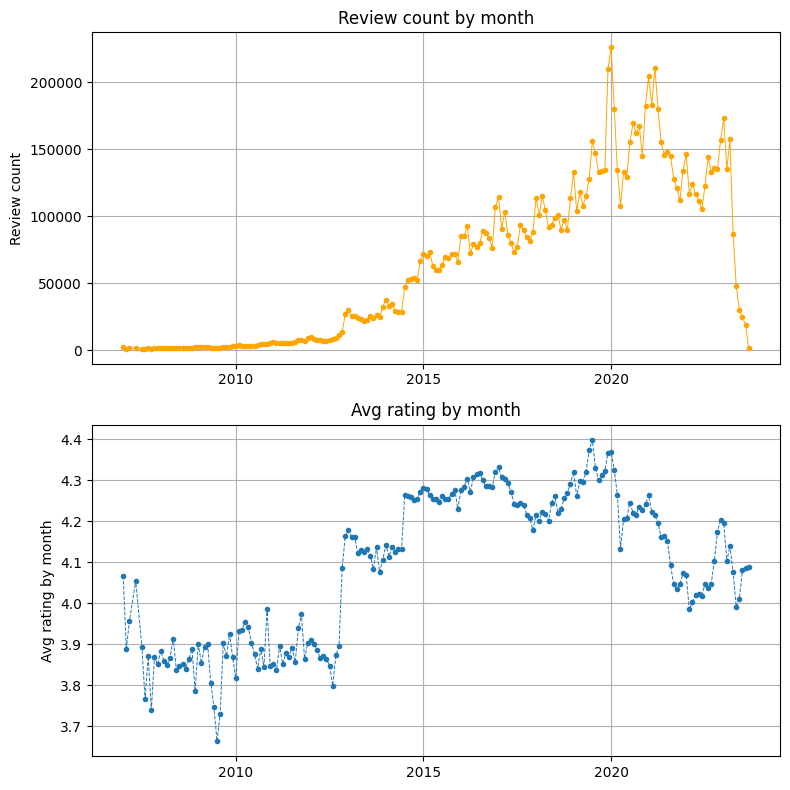

In [38]:
trend_pd_filtered = trend_pd[trend_pd['count'] >= 1000]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

year_ticks = trend_pd_filtered[trend_pd_filtered['month'] == 1 & trend_pd_filtered['year'].mod(5).eq(0)]

axes[0].plot(trend_pd_filtered['count'], linestyle='-', marker='.', linewidth=0.7, c='orange')
axes[0].set_ylabel("Review count")
axes[0].set_title("Review count by month")
axes[0].set_xticks(year_ticks.index)
axes[0].set_xticklabels(year_ticks["year"])
axes[0].grid(True)

axes[1].plot(trend_pd_filtered['avg_rating'], linestyle='--', marker='.', linewidth=0.7)
axes[1].set_ylabel("Avg rating by month")
axes[1].set_title("Avg rating by month")
axes[1].set_xticks(year_ticks.index)
axes[1].set_xticklabels(year_ticks["year"])
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Verified Purchase

### Ratio

In [49]:
verified_count = joined_df.filter(col("verified_purchase") == True).count()

In [43]:
verified_count, verified_count / joined_df.count()

(11999060, 0.9340906911193401)

### Rating compare

In [50]:
joined_df.groupBy("verified_purchase").agg(
    avg("rating").alias("avg_rating")
).show()

+-----------------+-----------------+
|verified_purchase|       avg_rating|
+-----------------+-----------------+
|             true|4.220628115869077|
|            false|4.021116113822444|
+-----------------+-----------------+



### Rating distribution (non-verified vs verified)

In [51]:
from pyspark.sql.functions import when

avg_rating_by_verified = joined_df.groupBy("parent_asin").agg(
    avg(when(col("verified_purchase") == True, col("rating"))).alias("verified_avg_rating"),
    avg(when(col("verified_purchase") == False, col("rating"))).alias("non_verified_avg_rating")
)

In [52]:
avg_rating_by_verified = avg_rating_by_verified.toPandas()

verified_avg_ratings = avg_rating_by_verified['verified_avg_rating']
non_verified_avg_ratings = avg_rating_by_verified['non_verified_avg_rating']

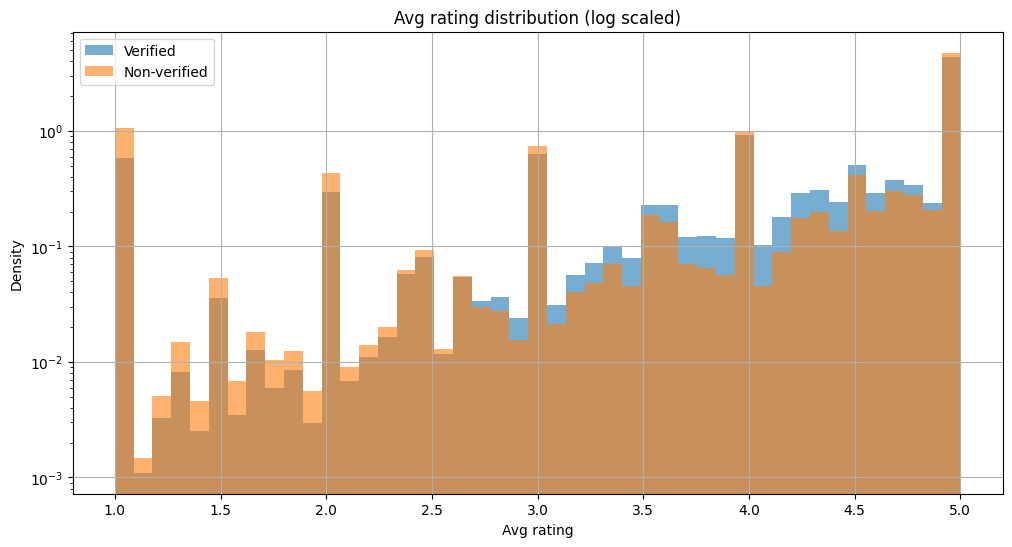

In [105]:
bins = 45

plt.figure(figsize=(12, 6))
plt.hist(verified_avg_ratings, bins=bins, alpha=0.6, density=True)
plt.hist(non_verified_avg_ratings, bins=bins, alpha=0.6, density=True)
plt.legend(["Verified", "Non-verified"])
plt.xlabel("Avg rating")
plt.ylabel("Density")
plt.yscale("log")
plt.title("Avg rating distribution (log scaled)")
plt.grid(True)
plt.show()